In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math
from functools import partial

import bases
import eigensolvers
import functionals
import generators
import representations
import reconstructions
import utils

import random
random.seed(1)

In [2]:
default_frequency = np.sqrt(2)/1000

In [3]:
class TestEigenfunc:
    def __init__(self, *args, **kwargs):
        self.frequency = kwargs.get('frequency', default_frequency)
        self.initial_state = kwargs.get('initial_state', 0)
        self.degree = kwargs.get('degree', 250)
        self.num_col = kwargs.get('num_col', 100000)
        self.representation_func = representations.mpEDMD_matrix_representation
    
    def get_true_eigenfunction(self, eigenvalue):
        """
        For the the frequency w, and the eigenvalue np.exp(1j*2*pi*n*w),
        the corresponding eigenfunction should be phi(x) = np.exp(1j*2*pi*n*x).
        """
        ev_angle = np.angle(eigenvalue)  # should be 2*pi*n*w
        ef_angle = ev_angle / self.frequency  # should be 2*pi*n
        ef = lambda x: np.exp(1j * ef_angle * x)  # should be phi(x) = np.exp(1j*2*pi*n*x)
        return ef
    
    def get_power_vector_with_true_eigenfunction(self, eigenvalues, basis):
        r = eigenvalues.shape[0]
        V = np.empty((r, r))
        for i in range(r):
            true_eigenfunction = self.get_true_eigenfunction(eigenvalues[i])
            p_vec = functionals.functional_inner_product(true_eigenfunction, basis, -np.pi, np.pi, input_size=1)
            V[:,i] = p_vec
        return V

    def get_power_function(self, eigenfunction, p, x):
        angle = np.angle(eigenfunction(x))
        return np.exp(1j*angle*p)

    def get_power_vector_with_one_true_eigenfunction(self, eigenvalues, basis):
        r = eigenvalues.shape[0]
        V = np.empty((r, r)).astype('complex128')
        true_eigenfunction = self.get_true_eigenfunction(eigenvalues[0])
        angles = np.angle(eigenvalues)
        for i in range(r):
            p = angles[i]/angles[0]
            assert np.isclose(eigenvalues[i], eigenvalues[0]**p)
            p_phi = lambda x: pow(true_eigenfunction(x), p)
            # p_phi = lambda x: np.exp(1j*np.angle(true_eigenfunction(x))*p)
            p_vec = functionals.functional_inner_product(p_phi, basis, -np.pi, np.pi, input_size=1)
            V[:,i] = p_vec
        return V

    def get_settings(self):
        Yr, Xr = utils.generate_krylov(partial(generators.angle_evolution, alpha=self.frequency), generators.unit_circle_observable_function, self.initial_state, self.num_col)
        utils.plot_complex_on_unit_circle(Yr)
        basis = partial(bases.fourier_basis, degree=self.degree, combinations=True)
        return Xr, basis
    
    def plot_eigenfunctions(self, domain, N, n_row, n_col, mp_ef_val, new_ef_val, tr_ef_val, pow_ef_val):
        fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(4*self.degree*n_col, 6*n_row))
        labels = ['mpEDMD', 'QR+EIG', 'QR+Power', 'True']
        for idx in range(N):
            if n_col==1:
                ax = axs[idx]
            else:
                i = idx//n_col
                j = idx%n_col
                ax = axs[i, j]
            ax.plot(domain, mp_ef_val[:,2*idx].real, 'b-.')
            ax.plot(domain, new_ef_val[:,2*idx].real, 'r--')
            ax.plot(domain, pow_ef_val[:,2*idx].real, 'm:')
            ax.plot(domain, tr_ef_val[:,2*idx].real, 'g-')
            ax.legend(labels)
        plt.show()

    def compare_on_unit_circle(self, val1, val2, val3, val4, n_row=3, N_max=20):
        n_col = 4
        fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))
        # fig.suptitle("eigenfunction value evolution")
        col_names = ['mpEDMD', 'True', 'QR+EIG', 'QR+Power']
        for c, name in enumerate(col_names):
            axs[0, c].set_title(name)
        for i in range(n_row):
            utils.set_subplot_complex_on_unit_circle(val1[:N_max,2*i], axs[i, 0], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val2[:N_max,2*i], axs[i, 1], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val3[:N_max,2*i], axs[i, 2], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val4[:N_max,2*i], axs[i, 3], add_color=True)
        plt.show()

    def show_orthogonality_heatmap(self, V, L, vmin=0, vmax=None, title='Title'):
        df = pd.DataFrame(abs(V.T@V.conj()), index=L, columns=L)
        fig, ax = plt.subplots(figsize=(4*self.degree, 3*self.degree))
        ax.set_title(title)
        sns.heatmap(df, vmin=vmin, vmax=vmax, linewidth=0.5, ax=ax, annot=True, fmt='.2f')
        plt.show()
        return

    def run(self):
        Xr, basis = self.get_settings()
        K, V, L = self.representation_func(Xr, basis=basis)
        eigenvalues, true_V, n = eigensolvers.QR_algorithm_with_inverse_iteration(K)
        return eigenvalues, true_V

In [4]:
def get_idx_of_highest_denominator(eigenvalues):
    thetas = np.angle(eigenvalues)/np.pi
    return np.argmax(np.array([theta.as_integer_ratio()[1] for theta in thetas if np.pi - 0.5 > abs(theta) > 0.5]))

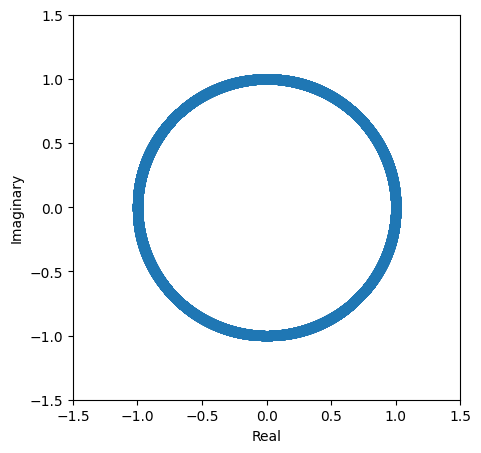

In [5]:
tef = TestEigenfunc()
Xr, basis = tef.get_settings()
K, V, L = tef.representation_func(Xr, basis=basis)

# $[U\varphi](x_i) = \lambda \varphi(x_i)$ ?
Note $[U\varphi](x_i) = \varphi(T(x_i)) = \varphi(x_{i+1})$

In [6]:
k = 0
Ph = lambda x: basis(x)@V[:,k]
for i in range(10):
    print(i, np.isclose(Ph(Xr[i+1]), L[k]*Ph(Xr[i])), np.linalg.norm(Ph(Xr[i+1]) - L[k]*Ph(Xr[i])))

0 [False] 0.004578777726208069
1 [False] 0.003459739840750515
2 [False] 0.0019689743678426913
3 [False] 0.0005097438422497616
4 [False] 0.0005630691127531962
5 [False] 0.0010525846087796357
6 [False] 0.0009679089030175021
7 [False] 0.0004966173999226992
8 [False] 8.268516445050326e-05
9 [False] 0.000510558915799311


# $[U\varphi^p](x_0) = \lambda^p \varphi^p(x_0)$ for $p \in \mathbb{Z}$?
Note $[U\varphi^p](x_0) = \varphi^p(T(x_0)) = \varphi^p(x_1)$

In [7]:
N = 5
M = 100
results = []
for n in range(-N, N+1):
    Phn = lambda x: Ph(x)**n
    Ln = pow(L[k], n)
    diff = sum(np.linalg.norm(Phn(Xr[i+1]) - Ln*Phn(Xr[i])) for i in range(M))/M
    results.append([n, Ln in L, np.isclose(diff, 0).item(), diff])
cols = ['n', 'is_in_eigenvalue', 'is_same', 'diff_norm']
df = pd.DataFrame(results, columns=cols)
df

n  is_in_eigenvalue  is_same  diff_norm
0  -5             False    False   0.001266
1  -4             False    False   0.001008
2  -3             False    False   0.000752
3  -2             False    False   0.000499
4  -1             False    False   0.000248
5   0             False     True   0.000000
6   1              True    False   0.000246
7   2             False    False   0.000489
8   3             False    False   0.000730
9   4             False    False   0.000968
10  5             False    False   0.001204

# upper bound of $p \in \mathbb{N}$ 

In [8]:
N = 20
results = []
for n in range(N+1):
    Phn = lambda x: Ph(x)**n
    Ln = pow(L[k], n)
    diff = sum(np.linalg.norm(Phn(Xr[i+1]) - Ln*Phn(Xr[i])) for i in range(M))/M
    results.append([n, Ln in L, np.isclose(diff, 0).item(), diff])
cols = ['n', 'is_in_eigenvalue', 'is_same', 'diff_norm']
df = pd.DataFrame(results, columns=cols)
df

n  is_in_eigenvalue  is_same  diff_norm
0    0             False     True   0.000000
1    1              True    False   0.000246
2    2             False    False   0.000489
3    3             False    False   0.000730
4    4             False    False   0.000968
5    5             False    False   0.001204
6    6             False    False   0.001437
7    7             False    False   0.001668
8    8             False    False   0.001897
9    9             False    False   0.002123
10  10             False    False   0.002347
11  11             False    False   0.002569
12  12             False    False   0.002789
13  13             False    False   0.003006
14  14             False    False   0.003221
15  15             False    False   0.003433
16  16             False    False   0.003644
17  17             False    False   0.003852
18  18             False    False   0.004058
19  19             False    False   0.004261
20  20             False    False   0.004463

In [9]:
def get_true_eigenfunction(eigenvalue):
    """
    For the the frequency w, and the eigenvalue np.exp(1j*2*pi*n*w),
    the corresponding eigenfunction should be phi(x) = np.exp(1j*2*pi*n*x).
    """
    ev_angle = np.angle(eigenvalue)  # should be 2*pi*n*w
    ef_angle = ev_angle / default_frequency  # should be 2*pi*n
    ef = lambda x: np.exp(1j * ef_angle * x)  # should be phi(x) = np.exp(1j*2*pi*n*x)
    return ef

def plot_eigenfunctions(N, Ph, eigenvalue):
    fig, axes = plt.subplots(nrows=N, ncols=1, figsize=(16, 6*N))
    labels = ['True', 'True+Power', 'QR+Power']
    domain = np.linspace(-0.1, 0.1, num=200)
    for idx, n in enumerate(range(N)):
        ax = axes[idx]
        ln = eigenvalue**n
        true_ef = get_true_eigenfunction(ln)
        true_power = lambda x: get_true_eigenfunction(eigenvalue)(x)**n
        power_ef = lambda x: Ph(x)**n

        ax.plot(domain, np.array([np.squeeze(true_ef(d)) for d in domain]).real, 'b-.')
        ax.plot(domain, np.array([np.squeeze(true_power(d)) for d in domain]).real, 'g:')
        ax.plot(domain, np.array([np.squeeze(power_ef(d)) for d in domain]).real, 'r--')
        ax.legend(labels)
        ax.set_title(f"power {n}")
        # print([true_ef(x)/true_power(x) for x in np.linspace(-np.pi, np.pi, num=10)])
    plt.show()

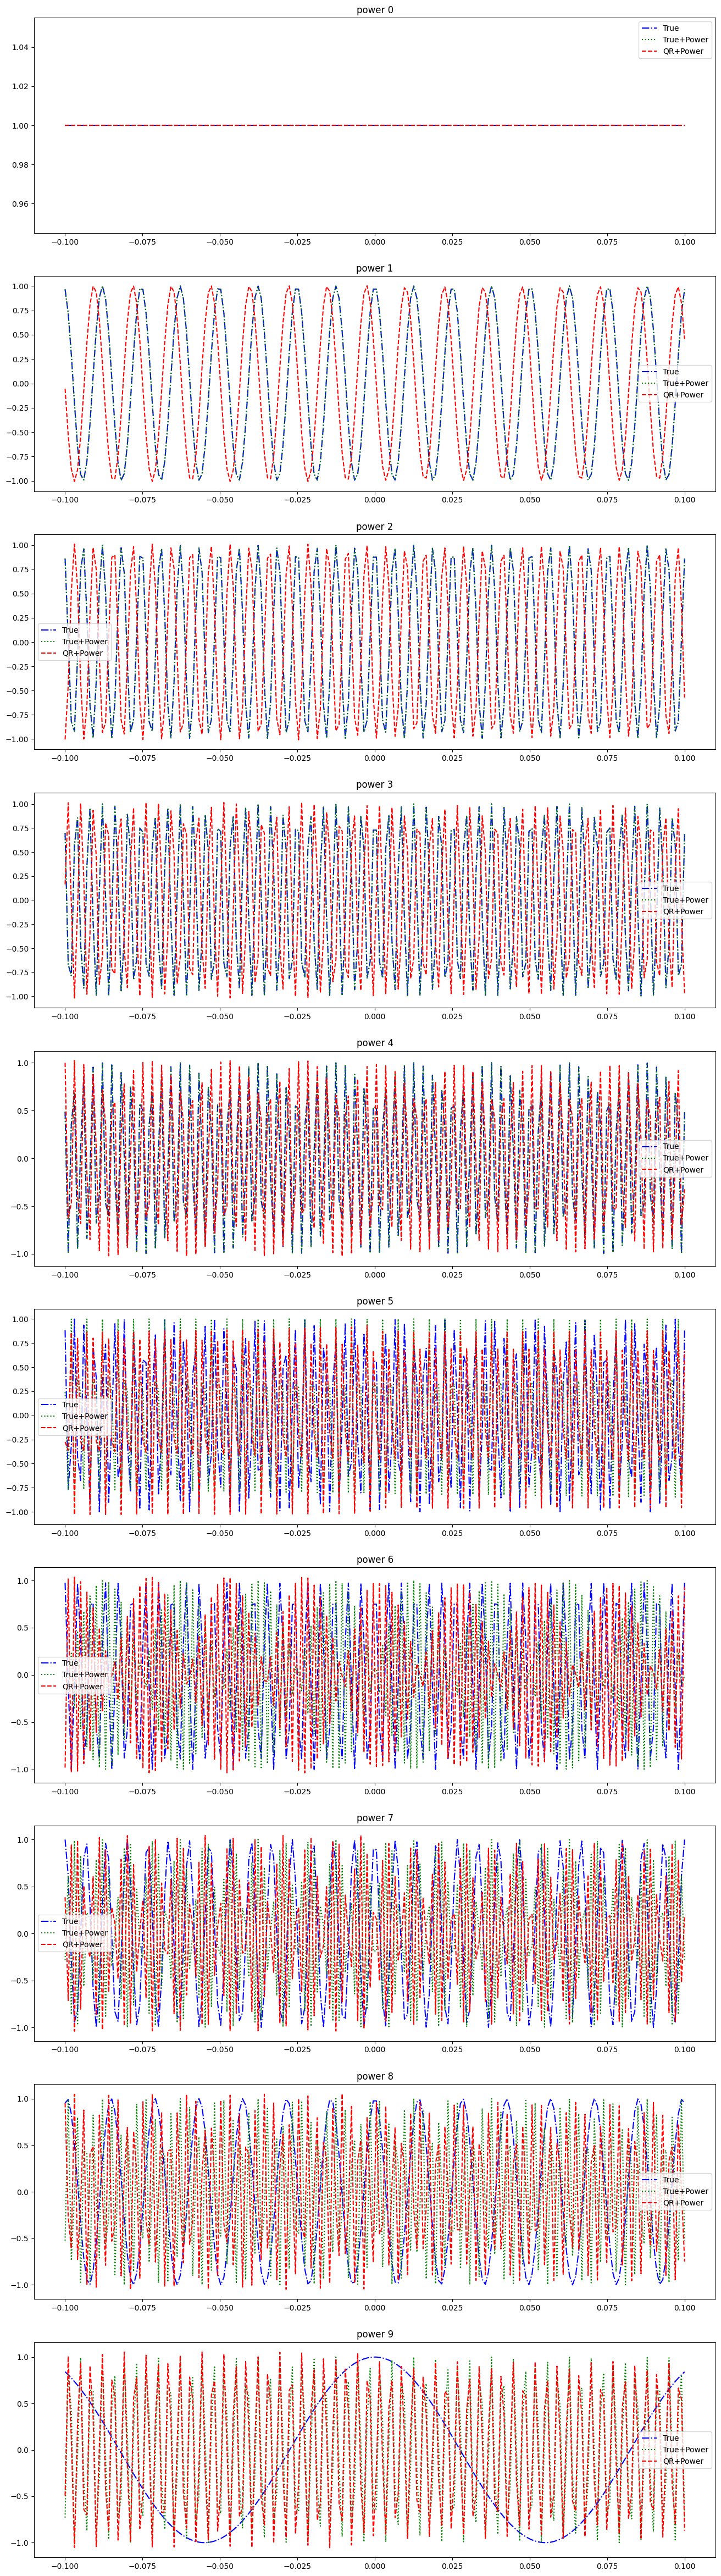

In [10]:
plot_eigenfunctions(10, Ph, L[k])